# Analysis of users behaviour for scooter-renting service "GoFast"
## Introduction
In this project we perform analysis of users and their behaviour for a short-term scooter-renting agencey "GoFast".
The company would like to know **how their users look like, how their behaviour depends on subscription, as well as to check several marketing theories**.  
The company has provided three **datasets**:  
users_go.csv with information about users: user_id, name, city, age, subscription type  
rides_go.csv with information about actions: user_id, lenght, distance, date  
subscriptions_go.csv with information about pricing for subscribed and not subscribed users  
It is **planned** to perform data cleaning (types, missing values, duplicates),  
to perform exploratory analysis (study desribution, get some insides, check for outliners),  
to combine the data in appropriate form for future analysis,  
to calculate service income, and to analyse how different users act.  
Finally, to check marketing theories.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from scipy.stats import poisson
from math import factorial
from scipy.stats import binom
from math import sqrt
import math

## Meeting the data

In [2]:
# Download the data
user_df = pd.read_csv(r'C:\Users\Ivan\datasetsYP\users_go.csv')
rides_df = pd.read_csv(r'C:\Users\Ivan\datasetsYP\rides_go.csv')
subs_df = pd.read_csv(r'C:\Users\Ivan\datasetsYP\subscriptions_go.csv')

# Study datasets
print('Information about users')
display(user_df.sample(10))
user_df.info()
print('\n Information about rides')
display(rides_df.sample(10))
rides_df.info()
print('\n Information about subscription policy')
display(subs_df.head())
subs_df.info()

Information about users


,user_id,name,age,city,subscription_type
299,300,Данила,27,Ростов-на-Дону,ultra
667,668,Андрей,25,Ростов-на-Дону,ultra
150,151,Майя,26,Омск,ultra
1208,1209,Борис,16,Омск,free
235,236,Владимир,13,Тюмень,ultra
412,413,Нелли,19,Ростов-на-Дону,ultra
1486,1487,Кирилл,26,Сочи,free
204,205,Тимофей,26,Пятигорск,ultra
1407,1408,Марат,23,Краснодар,free
1555,72,Никита,25,Москва,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB

 Information about rides


,user_id,distance,duration,date
6278,672,2342.731003,13.812605,2021-09-08
5852,623,3349.154054,17.134057,2021-10-31
10403,985,3989.197512,25.945988,2021-08-12
14400,1272,4999.540535,24.110090,2021-01-16
6309,676,3190.494313,15.362679,2021-08-06
15199,1330,4017.069557,16.608006,2021-02-09
8267,831,2203.924563,14.407849,2021-02-25
12710,1154,809.977894,4.943947,2021-06-26
11000,1028,3819.495417,16.963901,2021-10-10
8529,851,5120.825786,23.630931,2021-02-09


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB

 Information about subscription policy


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


There are no missing values in datasets.  
All the columns have correct data type, except date.

## Cleaning the data

Transformation of date type, creating information about the month of the ride.  
Checking for duplicates.

In [3]:
# Manipulations with date
rides_df['date'] = pd.to_datetime(rides_df['date'], format='%Y-%m-%dT')
rides_df['month'] = rides_df['date'].dt.month

# Information about duplicates
print('Duplicates in users dataset \n', user_df.duplicated().sum())
print('Duplicates in rides dataset \n', rides_df.duplicated().sum())

Duplicates in users dataset 
 31
Duplicates in rides dataset 
 0


In [4]:
# Get rid of full duplicates in users dataset
user_df = user_df.drop_duplicates()
print('Are there still duplicates in users dataset? \n', user_df.duplicated().sum() != 0)

# We also do not need user name for this analysis
user_df = user_df.drop('name', axis=1)

Are there still duplicates in users dataset? 
 False


The required simple manipulation with the data was performed. There was a few duplicates in users dataset, their amount was small, and they were dropped.  
In general the data is in a very good shape.

We should also check which dates are in dataset. It is important to work correctly with information about months.

In [5]:
print('Data collected from:', rides_df['date'].min())
print('Data collected till:', rides_df['date'].max())

Data collected from: 2021-01-01 00:00:00
Data collected till: 2021-12-30 00:00:00


Data is given only from one year (2021), so there are no problems for future time analysis.

## Exploratory data analysis

We should analyze general information about users and rides, in particular:  
4.1 Desctribution of data by city;  
4.2 Users with/without subscription;  
4.3 Age of users;  
4.4 Rides distance;  
4.5 Rides lenght;
Meanwhile, it is important to check for outlines.

### Desctribution of data by city

We should check which cities are present and what is data distribution among them.

Total cities: 8 
Their names: ['Тюмень' 'Омск' 'Москва' 'Ростов-на-Дону' 'Краснодар' 'Пятигорск'
 'Екатеринбург' 'Сочи']

Users per city


Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

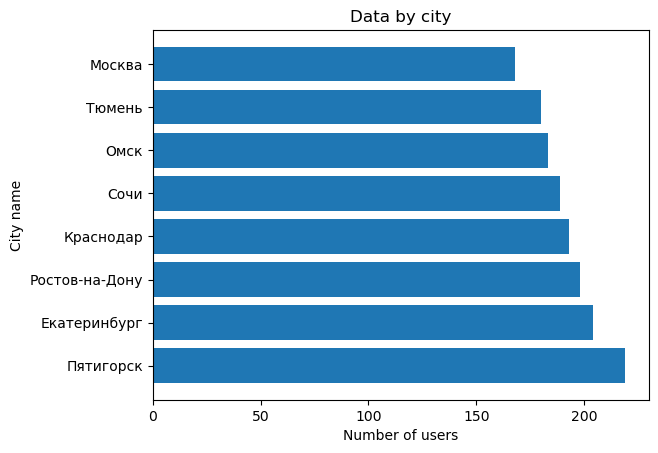

In [6]:
print('Total cities:', user_df['city'].nunique(), '\nTheir names:', user_df['city'].unique())
print('\nUsers per city')
display(user_df['city'].value_counts())

plt.barh(user_df['city'].value_counts().index, user_df['city'].value_counts())
plt.title(label='Data by city', loc='center')
plt.xlabel("Number of users")
plt.ylabel("City name")
plt.show()


### Users with/without subscription

Users with/without subscription are distributed almost evenly in two groups.

Users with different subscription types free     835
ultra    699
Name: subscription_type, dtype: int64


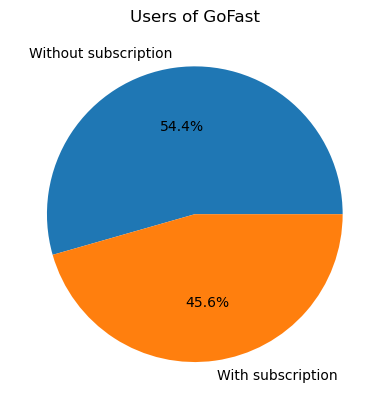

In [7]:
print('Users with different subscription types', user_df['subscription_type'].value_counts())
fig, ax = plt.subplots()
ax.pie(user_df['subscription_type'].value_counts(),
       labels=['Without subscription', 'With subscription'], autopct='%1.1f%%')
plt.title(label='Users of GoFast', loc='center')
plt.show()

### Age of users

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

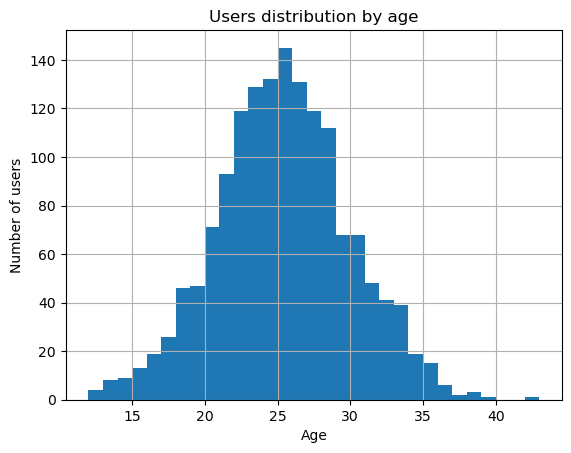

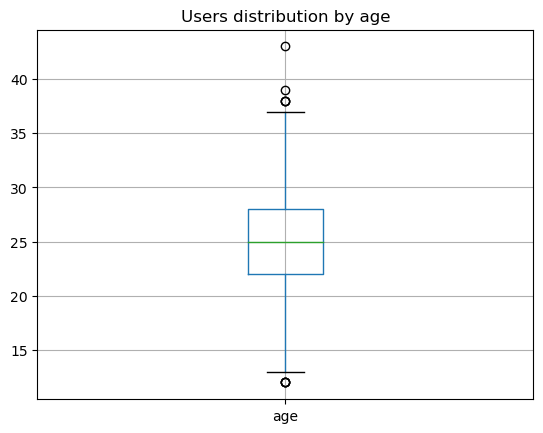

In [8]:
display(user_df['age'].describe())

user_df['age'].hist(bins = 31)
plt.title(label='Users distribution by age', loc='center')
plt.xlabel("Age")
plt.ylabel("Number of users")
plt.show()

user_df.boxplot(column='age')
plt.title(label='Users distribution by age', loc='center')
plt.show()

**Age of users** mostly located around 25 years and has normal destribution.

### Rides distance

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

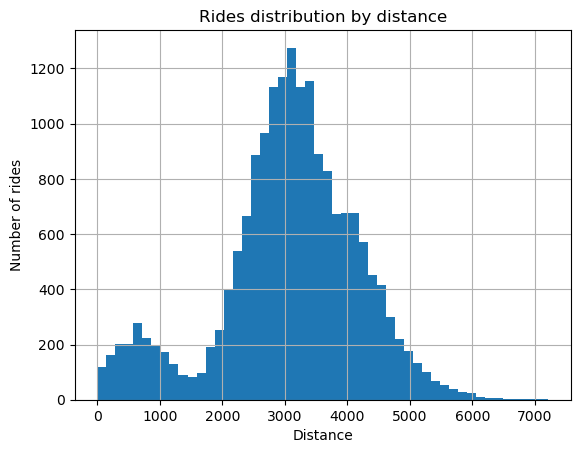

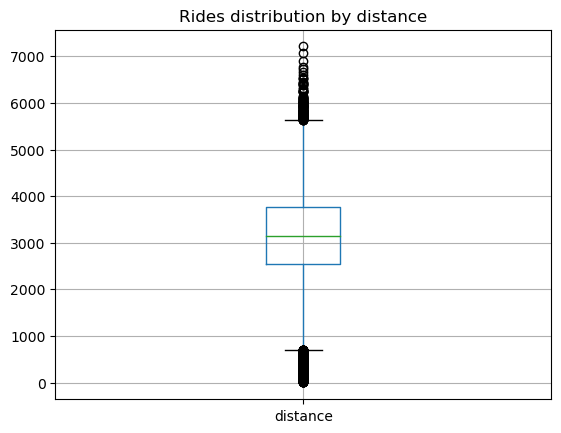

In [9]:
display(rides_df['distance'].describe())

rides_df['distance'].hist(bins = 50)
plt.title(label='Rides distribution by distance', loc='center')
plt.xlabel("Distance")
plt.ylabel("Number of rides")
plt.show()

rides_df.boxplot(column='distance')
plt.title(label='Rides distribution by distance', loc='center')
plt.show()

**Rides distance** has distribution with two maxima. The main maximum is around 3000 meters, the smallest one is around 500 meters, both have distribution close to normal.  
It is hard to conclude on difference of these two groups, it may be assumed that shorter rides correspond to the users who go to public transportation points (thus, distance is rather small), and main maximum corresponds to the users who perform a whole ride on the scooter.

### Rides lenght

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

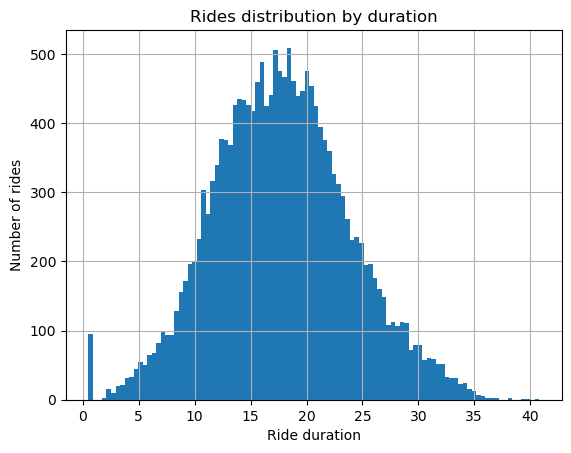

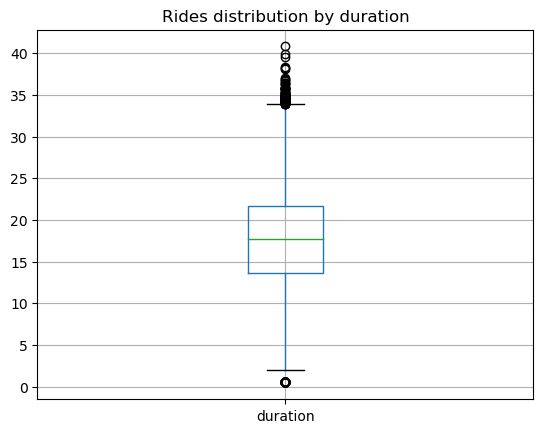

In [10]:
display(rides_df['duration'].describe())

rides_df['duration'].hist(bins = 100)
plt.title(label='Rides distribution by duration', loc='center')
plt.xlabel("Ride duration")
plt.ylabel("Number of rides")
plt.show()

rides_df.boxplot(column='duration')
plt.title(label='Rides distribution by duration', loc='center')
plt.show()

**Rides duration** on the contrary to distance has normal distribution with one maximum around 17 minutes.  
There is a group of rides which is outlined at 1 min, however it is yet not clear if there is a problem with the data, or it is users who started and then decided to stop the ride immediately.

It is intriguing that time and distance has different distribution. It would be important to check correlation between them.

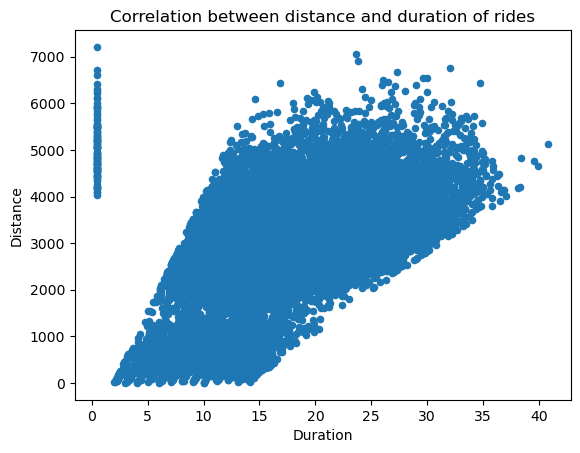

0.5367776552505347


In [11]:
rides_df.plot(x='duration', y='distance', kind='scatter')
plt.title(label='Correlation between distance and duration of rides', loc='center')
plt.xlabel("Duration")
plt.ylabel("Distance")
plt.show()
print(rides_df['distance'].corr(rides_df['duration']))

In general the correlation is rather good, with broad variety of duration even for short distance.  
However, the group of very short rides for a long distance looks suspicious.  

In [12]:
# Taking a closer look on the short rides
display(rides_df.loc[rides_df['duration'] <= 1])
display(rides_df.loc[rides_df['duration'] <= 1].describe())

,user_id,distance,duration,date,month
6531,701,4196.445201,0.5,2021-08-31,8
6570,704,4830.824371,0.5,2021-10-14,10
6680,712,4684.004397,0.5,2021-03-04,3
6695,713,5215.642710,0.5,2021-02-25,2
6768,718,5197.436649,0.5,2021-02-11,2
...,...,...,...,...,...
17004,1460,5531.335845,0.5,2021-01-19,1
17242,1477,6724.932981,0.5,2021-01-12,1
17314,1483,4445.481070,0.5,2021-03-06,3
17505,1496,5722.551787,0.5,2021-02-14,2


,user_id,distance,duration,month
count,95.000000,95.000000,95.0,95.000000
mean,1092.210526,5113.176549,0.5,6.484211
std,244.028551,658.254104,0.0,3.709858
min,701.000000,4030.308008,0.5,1.000000
25%,901.000000,4611.510820,0.5,3.000000
50%,1069.000000,5052.769411,0.5,6.000000
75%,1310.500000,5488.459099,0.5,10.000000
max,1524.000000,7211.007745,0.5,12.000000


At a closer look on the short rides, it seems that there is no correlation with any other parameters.  
It is probably a mistake in metrics collection, or a safety leak.  
As a value of 95 is a small portion of the dataset, for us it is more convinient to drop this data.

In [13]:
rides_df = rides_df.drop(rides_df[rides_df['duration'] <= 1].index)
rides_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17973 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   17973 non-null  int64         
 1   distance  17973 non-null  float64       
 2   duration  17973 non-null  float64       
 3   date      17973 non-null  datetime64[ns]
 4   month     17973 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 842.5 KB


### Conclusion
There is the data on 8 cities with rather even distribution of users.  
Most of the service users are young people of age 20-30.  
Distribution of users with and without subscription is also even.  
Duration and distance of rides have distribution close to normal, while in case of distance, there is the additional group of short rides.  
A group of outliners with very short duration but very long distance was detected, this data was removed for further analysis, but should be carefully considered as may indicate problems with data collection.

## Data manipulation

For convenience of further analysis we should perform a series of manipulations with data:  
5.1 To combine information about users, rides, and tarifs in one dataframe.  
5.2 To split it to have easy acces to users with and without subscription.  
5.3 To study how subscription type affects users' behaviour.

### Data combination

In [14]:
# User_id is common for both - rides and users datasets
full_df = user_df.merge(rides_df, left_on='user_id', right_on='user_id')

# Adding data from the tarifs data frame
full_df['minute_price'] = full_df.apply(lambda row:
                   (8) if row['subscription_type'] =='free' 
                   else (6), axis=1)
full_df['start_ride_price'] = full_df.apply(lambda row:
                   (50) if row['subscription_type'] =='free' 
                   else (0), axis=1)
full_df['subscription_fee'] = full_df.apply(lambda row:
                   (0) if row['subscription_type'] =='free' 
                   else (199), axis=1)

# Check that everything is well-combined
display(full_df.sample(10))
display(full_df.info())

,user_id,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
14096,1255,21,Пятигорск,free,3336.488242,22.703882,2021-09-28,9,8,50,0
9943,955,18,Сочи,free,3845.204560,32.226023,2021-12-15,12,8,50,0
10284,979,20,Екатеринбург,free,4958.336022,24.657903,2021-12-18,12,8,50,0
14761,1304,25,Сочи,free,3017.112991,18.620323,2021-11-08,11,8,50,0
13126,1189,26,Екатеринбург,free,4009.997396,10.911105,2021-05-16,5,8,50,0
2605,276,20,Сочи,ultra,3249.911794,11.723955,2021-08-29,8,6,0,199
17865,1528,25,Пятигорск,free,3909.678110,15.688174,2021-07-12,7,8,50,0
568,62,21,Пятигорск,ultra,3298.860139,24.494301,2021-12-07,12,6,0,199
16565,1432,23,Тюмень,free,2420.728232,20.314943,2021-05-02,5,8,50,0
15297,1344,21,Тюмень,free,3300.947062,22.146916,2021-07-09,7,8,50,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 17973 entries, 0 to 17972
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            17973 non-null  int64         
 1   age                17973 non-null  int64         
 2   city               17973 non-null  object        
 3   subscription_type  17973 non-null  object        
 4   distance           17973 non-null  float64       
 5   duration           17973 non-null  float64       
 6   date               17973 non-null  datetime64[ns]
 7   month              17973 non-null  int64         
 8   minute_price       17973 non-null  int64         
 9   start_ride_price   17973 non-null  int64         
 10  subscription_fee   17973 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(2)
memory usage: 1.6+ MB


None

### Separation into two dataframes

In [15]:
df_no_subs = full_df.loc[full_df['subscription_type'] == 'free']
df_subs = full_df.loc[full_df['subscription_type'] == 'ultra']
print('Data about users without subscription\n')
display(df_no_subs.info())
print('\nData about users with subscription\n')
display(df_subs.info())

Data about users without subscription

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11473 entries, 6500 to 17972
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            11473 non-null  int64         
 1   age                11473 non-null  int64         
 2   city               11473 non-null  object        
 3   subscription_type  11473 non-null  object        
 4   distance           11473 non-null  float64       
 5   duration           11473 non-null  float64       
 6   date               11473 non-null  datetime64[ns]
 7   month              11473 non-null  int64         
 8   minute_price       11473 non-null  int64         
 9   start_ride_price   11473 non-null  int64         
 10  subscription_fee   11473 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(2)
memory usage: 1.1+ MB


None


Data about users with subscription

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6500 entries, 0 to 6499
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            6500 non-null   int64         
 1   age                6500 non-null   int64         
 2   city               6500 non-null   object        
 3   subscription_type  6500 non-null   object        
 4   distance           6500 non-null   float64       
 5   duration           6500 non-null   float64       
 6   date               6500 non-null   datetime64[ns]
 7   month              6500 non-null   int64         
 8   minute_price       6500 non-null   int64         
 9   start_ride_price   6500 non-null   int64         
 10  subscription_fee   6500 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(2)
memory usage: 609.4+ KB


None

Interestingly, users without subscription made almost twice more rides then users with subscription, while amount of users in two groups is almost the same. We will study it in details later on.

### Comparison of the users with and without subscription
Let's analyse duration and distance of rides for both subscription types. In general they looks similar, while distribution for users without subscribtion is a bit broader. They also make shorter rides.  
Difference in duration for both types of users is neglectable.

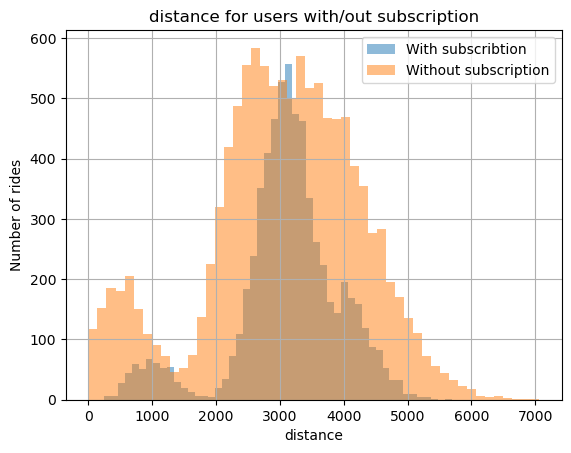

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

count    11473.000000
mean      3028.374239
std       1235.541051
min          0.855683
25%       2360.878149
50%       3102.083025
75%       3883.979311
max       7066.003772
Name: distance, dtype: float64

In [16]:
def subs_no_subs_comparision(parametr):
    df_subs[parametr].hist(bins = 50, alpha=0.5, label='With subscribtion')
    df_no_subs[parametr].hist(bins = 50, alpha=0.5, label='Without subscription')
    plt.legend(loc='upper right')
    plt.title(label=f"{parametr} for users with/out subscription", loc='center')
    plt.xlabel(f"{parametr}")
    plt.ylabel("Number of rides")
    plt.show()
    display(df_subs[parametr].describe())
    display(df_no_subs[parametr].describe())

    
subs_no_subs_comparision('distance')

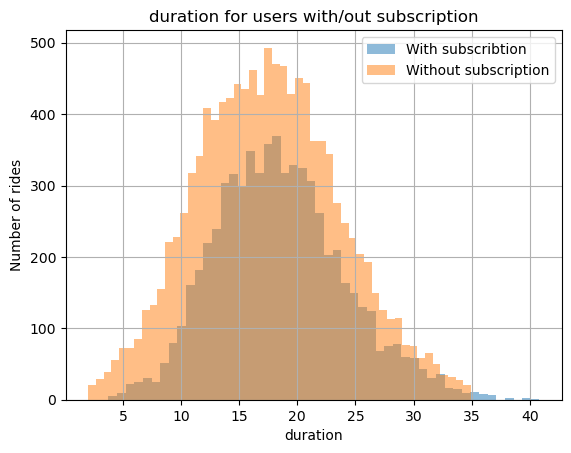

count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64

count    11473.000000
mean        17.530771
std          6.162609
min          2.035632
25%         13.085688
50%         17.383807
75%         21.638038
max         34.948498
Name: duration, dtype: float64

In [17]:
subs_no_subs_comparision('duration')

### Conclusion
At first glance, users with and without subscription have similar behaviour and their rides have similar distribution both in distance and in duration.

## Income calculation

### Pivot dataset
To proceed with further analysis aggregation of data is neccesary. The most valuble output would be: total distance, number of rides, total time by user by month.

In [18]:
# Rounding up to nearest int
# Important for correct calculation of price, since every single ride is being rounded up to minute
full_df['duration'] = np.ceil(full_df['duration']) 

# Creating pivot table
agg_df = pd.pivot_table(full_df, values=['duration', 'distance', 'subscription_type', 'minute_price',
                                         'start_ride_price', 'subscription_fee'],
                        index=['user_id', 'month'],
                        aggfunc={'duration': np.sum, 'distance': np.sum, 'user_id': 'count',
                                 'subscription_type': 'unique', 'minute_price': 'first',
                                 'start_ride_price': 'first','subscription_fee': 'first'
                                })

# Renaming the columns
agg_df.columns = ['total_distance', 'total_duration', 'minute_price', 'start_ride_price',
                  'subscription_fee', 'subcription_type', 'n_usages']

# Meeting the data
display(agg_df.sample(20))
display(agg_df.info())
display(agg_df.stack())
display(agg_df.describe())

,,total_distance,total_duration,minute_price,start_ride_price,subscription_fee,subcription_type,n_usages
user_id,month,,,,,,,
691,11,4288.003409,16.0,6,0,199,[ultra],1
1271,5,4658.040644,26.0,8,50,0,[free],1
1521,6,7045.326893,34.0,8,50,0,[free],2
278,5,6074.957699,42.0,6,0,199,[ultra],2
593,1,2755.285035,24.0,6,0,199,[ultra],1
1444,12,4857.350959,25.0,8,50,0,[free],1
1054,8,4044.468902,24.0,8,50,0,[free],1
772,11,6520.072460,47.0,8,50,0,[free],2
535,2,2802.634345,13.0,6,0,199,[ultra],1


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11300 entries, (1, 1) to (1534, 12)
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   total_distance    11300 non-null  float64
 1   total_duration    11300 non-null  float64
 2   minute_price      11300 non-null  int64  
 3   start_ride_price  11300 non-null  int64  
 4   subscription_fee  11300 non-null  int64  
 5   subcription_type  11300 non-null  object 
 6   n_usages          11300 non-null  int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 663.3+ KB


None

user_id  month                  
1        1      total_distance      7027.511294
                total_duration             42.0
                minute_price                  6
                start_ride_price              0
                subscription_fee            199
                                       ...     
1534     12     minute_price                  8
                start_ride_price             50
                subscription_fee              0
                subcription_type         [free]
                n_usages                      1
Length: 79100, dtype: object

,total_distance,total_duration,minute_price,start_ride_price,subscription_fee,n_usages
count,11300.000000,11300.000000,11300.000000,11300.000000,11300.000000,11300.000000
mean,4866.808201,29.257788,7.197699,29.942478,79.828938,1.590531
std,2883.520342,16.709409,0.980306,24.507653,97.540460,0.827678
min,2.570787,3.000000,6.000000,0.000000,0.000000,1.000000
25%,2964.613521,17.000000,6.000000,0.000000,0.000000,1.000000
50%,3972.551070,24.000000,8.000000,50.000000,0.000000,1.000000
75%,6391.866884,38.000000,8.000000,50.000000,199.000000,2.000000
max,23429.487786,143.000000,8.000000,50.000000,199.000000,7.000000


According to the grouped data, users do not use the service frequently.  
In average, number of 2 uses per month by user is less then 25% (!), taking into account that around 40% of users take subscription it is likely to indicate some problems with user experience.

### Income per user
We can add income per month per user to the pivot table.

In [19]:
# Small reminder on the subscription policy
display(subs_df)

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [20]:
# As we already added all the details about tarif in combined and then pivot table, we can use it
# To alculate income in general form

agg_df['income'] = (agg_df['total_duration'] * agg_df['minute_price'] + agg_df['subscription_fee'] + 
                    agg_df['n_usages'] * agg_df['start_ride_price'])

display(agg_df.sample(20))

,,total_distance,total_duration,minute_price,start_ride_price,subscription_fee,subcription_type,n_usages,income
user_id,month,,,,,,,,
331,2,5780.578725,41.0,6,0,199,[ultra],2,445.0
430,7,3078.720379,13.0,6,0,199,[ultra],1,277.0
92,9,981.468852,16.0,6,0,199,[ultra],1,295.0
102,10,3844.018047,36.0,6,0,199,[ultra],2,415.0
915,5,5278.894876,24.0,8,50,0,[free],2,292.0
357,8,10038.730302,54.0,6,0,199,[ultra],3,523.0
1001,5,16468.397049,75.0,8,50,0,[free],4,800.0
976,11,11767.233372,61.0,8,50,0,[free],3,638.0
876,1,2142.011960,20.0,8,50,0,[free],1,210.0


### Studiyng income regularities

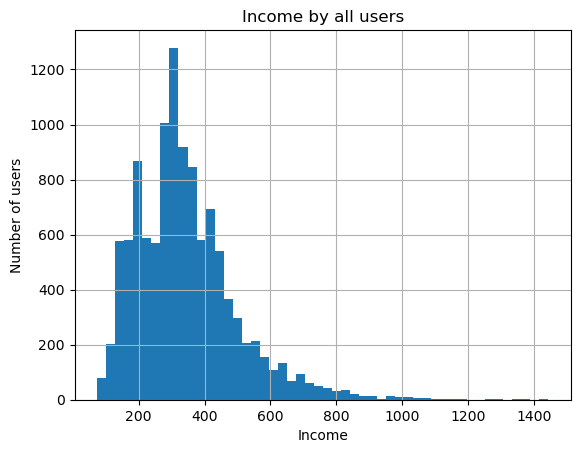

count    11300.000000
mean       342.754956
std        153.317314
min         74.000000
25%        234.000000
50%        319.000000
75%        415.000000
max       1444.000000
Name: income, dtype: float64


Income by subscription type



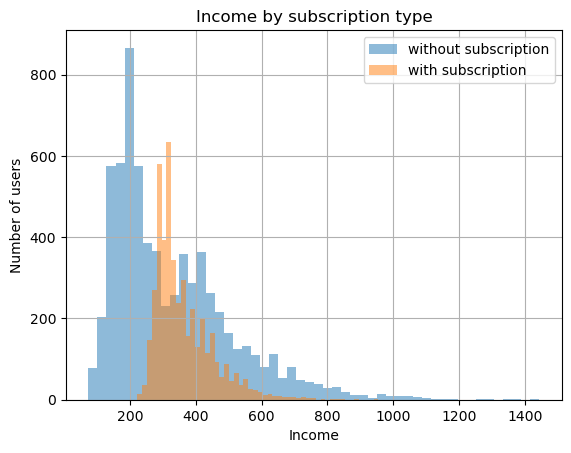

Without subscription:



count    6767.000000
mean      329.332644
std       183.268419
min        74.000000
25%       194.000000
50%       274.000000
75%       428.000000
max      1444.000000
Name: income, dtype: float64


With subscription:



count    4533.000000
mean      362.792191
std        88.262737
min       223.000000
25%       301.000000
50%       337.000000
75%       409.000000
max       955.000000
Name: income, dtype: float64

Month*Users with subscription: 4533
Month*Users without subscription: 6767


In [21]:
agg_df['income'].hist(bins = 50)
plt.title(label='Income by all users', loc='center')
plt.xlabel("Income")
plt.ylabel("Number of users")
plt.show()
display(agg_df['income'].describe())


print('\nIncome by subscription type\n')
agg_df.loc[agg_df['subcription_type'] == 'free']['income'].hist(
                                    bins = 50, alpha=0.5, label='without subscription')
agg_df.loc[agg_df['subcription_type'] == 'ultra']['income'].hist(
                                    bins = 50, alpha=0.5, label='with subscription')
plt.legend(loc='upper right')
plt.title(label='Income by subscription type', loc='center')
plt.xlabel("Income")
plt.ylabel("Number of users")
plt.show()
print('Without subscription:\n')
display(agg_df.loc[agg_df['subcription_type'] == 'free']['income'].describe())
print('\nWith subscription:\n')
display(agg_df.loc[agg_df['subcription_type'] == 'ultra']['income'].describe())

print('Month*Users with subscription:',
      agg_df.loc[agg_df['subcription_type'] == 'ultra']['income'].count())
print('Month*Users without subscription:',
      agg_df.loc[agg_df['subcription_type'] == 'free']['income'].count())

The general distribution has two maxima, which are cleary distinguished by subscription type.  
In average, users with subscription spend 337 russian rubles per month, while users without only 274 russian rubles.  
This subscription unefficiency is related to the low return rate of users.

### Conclusion
At this stage, the monthly revenue per user was calculated. For these purposes, the data were grouped accordingly, and the total indicators for the use of the service were calculated. According to the preliminary analysis, it is clear that users with a subscription, in average, bring more money to the service. Let's see if this is true in the next section.

To try to get futher insides into data a correlation of all data in the combined dataframe was checked. It was then interesting to see correlation between age (and user_id) with distance, as well as if it is geographically different.  
No additional correlation were found, meaning that the nature of two maximal distribution of rides distance has no additional explanation.

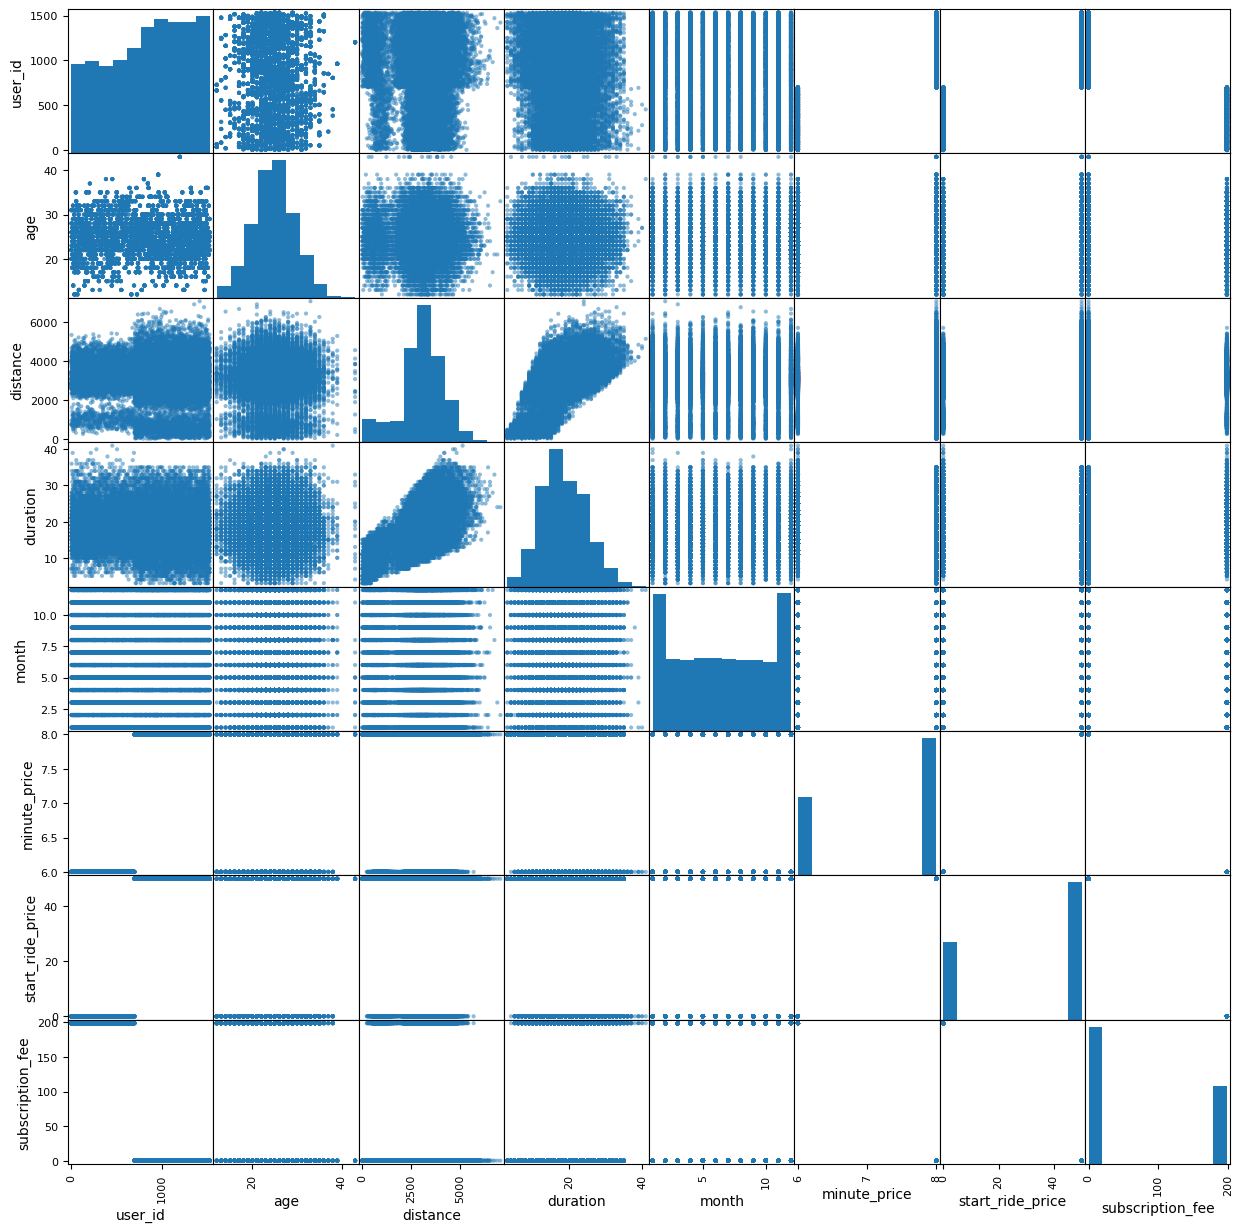

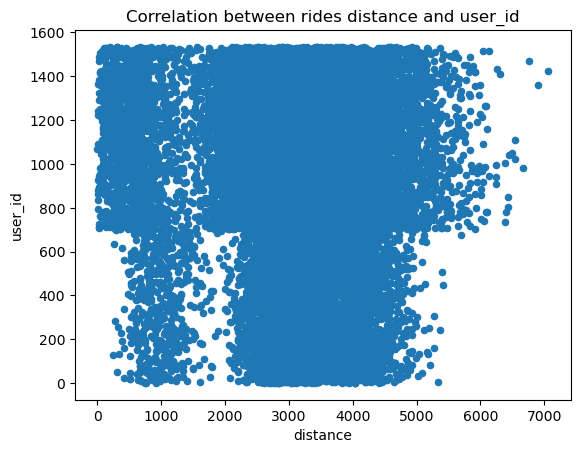

Correlation between rides distance and user_id: -0.037379438261277216 



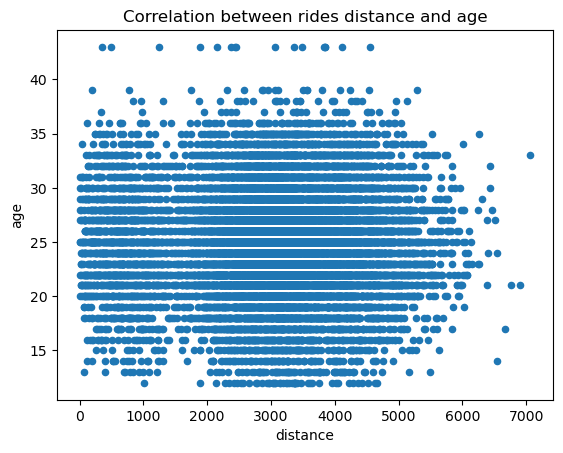

Correlation between rides distance and user_id: -0.0006232805533939764 



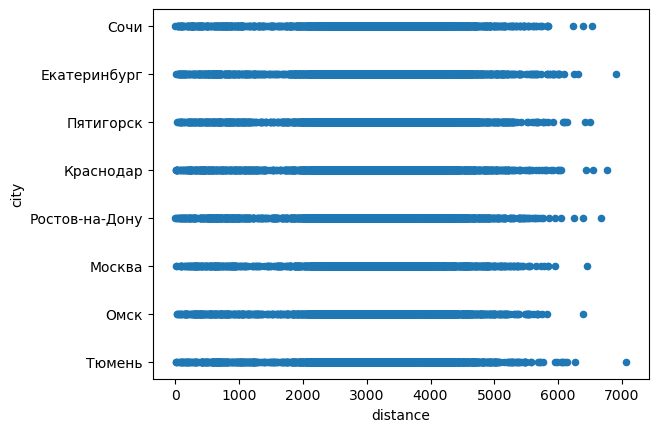

In [22]:
# All data correlation
pd.plotting.scatter_matrix(full_df, figsize=(15, 15))
plt.show()

# Distance with user_id
full_df.plot(x='distance', y='user_id', kind='scatter')
plt.title(label='Correlation between rides distance and user_id', loc='center')
plt.xlabel("distance")
plt.ylabel("user_id")
plt.show()
print('Correlation between rides distance and user_id:', full_df['distance'].corr(full_df['user_id']), '\n')

full_df.plot(x='distance', y='age', kind='scatter')
plt.title(label='Correlation between rides distance and age', loc='center')
plt.xlabel("distance")
plt.ylabel("age")
plt.show()
print('Correlation between rides distance and user_id:', full_df['distance'].corr(full_df['age']), '\n')

# By city, while it is not recommended to use scatter for catgoral data, it still can give useful information
full_df.plot(x='distance', y='city', kind='scatter');

## Hypothesis trial

Product managers of the service want to increase the number of users with the subscription. To do this, they will offer various promotions, but first we need to find out a few important points.  
7.1 It is important to understand whether users with a subscription spend more time traveling? If yes, then users with the subscription can be beneficial for the company. Let's test the hypothesis based on the raw data on the duration of each session - separately for subscribers and those who do not have the subscription.  
7.2 The distance of one trip of 3130 meters is optimal in terms of scooter wear. Can we say that the distance travelled by users with the subscription in one trip does not exceed 3130 meters?   
7.3. Let's test the hypothesis on whether the monthly revenue from users with the monthly subscription is higher than the revenue from users without the subscription as it seems from the preliminary analysis.  

### Rides duration for different subscription category
Null hypothesis: users with and without subscription spend same time for rides.  
Alternative hypothesis: time spent by users with subscribtion is higher then for users without the subscription.

In [23]:
# Lets' make alpha 5% 
alpha = 0.05

results_first = st.ttest_ind(df_subs['duration'],
                     df_no_subs['duration'],
                     equal_var=False,
                     alternative='greater')

print(results_first.pvalue)

if (results_first.pvalue < alpha):
    print('Discarding the null hypothesis')
else:
    print('We cannot discard the null hypothesis')


1.6162210195311063e-29
Discarding the null hypothesis


The common level of statistical significance is 0.05, we will use it to test this hypothesis and the subsequent ones.  
p value is very small, less than the level of statistical significance. This tells us that the null hypothesis needs to be dropped, which means that the data is not equal, and the users with the subscription spend more time.  
Indeed, from point 6.3 we know that the average travel time for users with the subscription is longer (18.5 min vs 17.5 min for users without the subscription).

### Rides distance
It is important to know if it exeeds 3130 meters. Thus:  
Null hypothesis: distance is equal to 3130,  
Alternative hypothesis: distance is smaller.

In [24]:
print('Data for users with subscription:')
results_two = st.ttest_1samp(
        df_subs['distance'], 
        3130,
        alternative='less')

print(results_two.pvalue)

if (results_two.pvalue < alpha):
    print('Discarding the null hypothesis')
else:
    print('We cannot discard the null hypothesis')
    
    
results_two_all = st.ttest_1samp(
        full_df['distance'], 
        3130,
        alternative='less')

print('\nData for all users:')
print(results_two_all.pvalue)

if (results_two_all.pvalue < alpha):
    print('Discarding the null hypothesis')
else:
    print('We cannot discard the null hypothesis')

Data for users with subscription:
0.08046311521502146
We cannot discard the null hypothesis

Data for all users:
1.2126211960199565e-17
Discarding the null hypothesis


Considering the dataset for users with subscription p value is less than statistical significance, which means that it cannot be argued that users drive less than 3130 meters in one trip. Indeed, the average value for the trips is very close to this value.
But in the case of considering all users, the null hypothesis can be rejected - in average, users drive less than 3130 m.

### Revenue from different user groups
Let's test the hypothesis statistically.  
Null hypothesis: subscribed and unsubscribed users spend the same amount of money.  
Alternative hypothesis: users with the subscription spend more.

In [25]:
results_three = st.ttest_ind(agg_df.loc[agg_df['subcription_type'] == 'free']['income'],
                     agg_df.loc[agg_df['subcription_type'] == 'ultra']['income'],
                     equal_var=False,
                     alternative='less')

print(results_three.pvalue)

if (results_three.pvalue < alpha):
    print('Discarding the null hypothesis')
else:
    print('We cannot discard the null hypothesis')

2.4970242872858465e-38
Discarding the null hypothesis


Indeed, it can be argued that subscribed users spend more money per month because the p value is less than the level of statistical significance (0.05 given at the beginning), and the null hypothesis of equality can be dropped. This also agrees with the graphical and descriptive data analysis carried out in Section 6.3.

### Conclusions
Using statistical methods, hypotheses were studied, the results confirmed the preliminary conclusions made on the basis of averages and graphs.  
Namely: users with the subscription drive longer and pay more. At the same time, users with the subscription drive longer than desired, although in general all users drive less than the threshold.

## Distributions
8.1 "GoFast's" Marketing Department has tasked with running a promocode giveaway for a free month of subscription, in which at least 100 existing customers must renew this subscription. That is, at the end of the subscription period, the user can either refuse it or extend it by making the appropriate payment.
This promotion has already been held before and as a result it turned out that after a free trial period, the subscription is renewed by 10% of users. Find out what is the minimum number of promo codes you need to send out, so that the probability of not fulfilling the plan is approximately 5%. Select the distribution parameters that describe this situation, build a distribution schedule and formulate an answer to the question about the number of promotional codes.
You need to use the binomial distribution that describes the specified situation. Then, choose the appropriate value of the parameter N for the given parameter p=0.1 using graphs and the cdf() method, formulate a conclusion and an answer.

8.2 The Marketing Department sends push notifications to customers on the mobile application. Customers may or may not open it. It is known that about 40% of the customers who receive the notifications open it. The department plans to send out 1 million notices. Use the approximation to plot an approximate distribution plot and estimate the probability that the notification will be opened by no more than 399.5 thousand users.
This situation is also described by the binomial distribution. But counting on each individuals' value is long enough. You can use the normal approximation of the binomial distribution and cdf() for a quick estimate.

### Promotion
First, we plot the graph for the assumed binomial distribution with a count of 100 attempts. It can be seen that the expectation is around 10. Since I feel sorry for my computer and don't want to count factorials for thousands, we need to approximate the binomial distribution. The problem looks suitable to be described by a Poisson distribution, since the probability of a positive outcome is small and the number of trials will be large.
Let us perform a simple parameter numeration for the Poisson distribution, it turns out that we need 1161 promocodes to get 100 users with a probability of 95 percent.

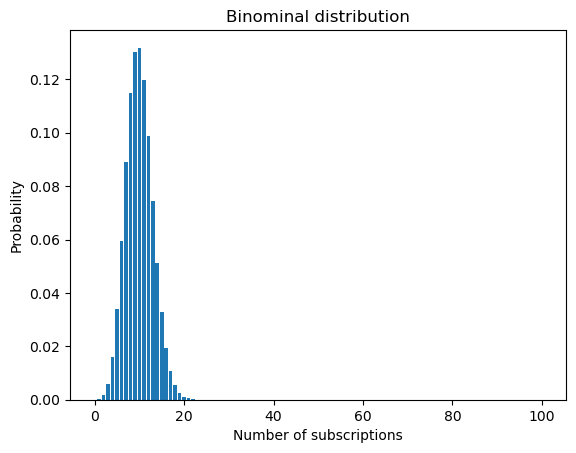

According to Poisson aproxim.:
1170 

0.950026622361561

According to biniminal distribution:

1170 

0.9583990515646115


In [26]:
# Binominal distribution
n = 100 # - requirement
p = 0.1 # - extension probability
alpha = 0.05 # -  level of statistical significance
distr = []

for k in range(0, n + 1):
    current_value = binom.pmf(k, n, p)
    distr.append(current_value)
    
plt.bar(range(0, n + 1), distr)
plt.title(label='Binominal distribution', loc='center')
plt.xlabel("Number of subscriptions")
plt.ylabel("Probability")
plt.show()

# Poisson
for x in range (1000, 2000, 10):
    if (1 - poisson.cdf(100 - 1, p*x)) > 0.95:
        print('According to Poisson aproxim.:')
        print(x, '\n')
        print(1 - poisson.cdf(100 - 1, p*x))
        break

# binominal
for x in range (1000, 2001, 10):
    if ((1 - binom.cdf((100 - 1), x, p)) > 0.95):
        print('\nAccording to biniminal distribution:\n')
        print(x, '\n')
        print(1- binom.cdf((100 - 1), x, p))
        break

### Newsletter
Let's build a normal distribution and a plot for the presented values.  
It turned out that the probability of a small number of views is about 15%.

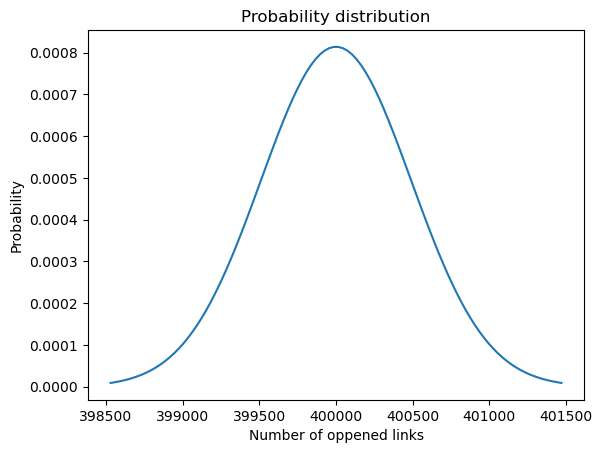

Probability that not more then 399.5k users will open the link: 0.15371708296369768


In [27]:
n_two = 1000000
p_two = 0.4

mu = n_two * p_two
sigma = sqrt(n_two * p_two * (1 - p_two))

distr_for_spam = st.norm(mu, sigma)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, st.norm.pdf(x, mu, sigma))
plt.title(label='Probability distribution', loc='center')
plt.xlabel("Number of oppened links")
plt.ylabel("Probability")
plt.show()

print('Probability that not more then 399.5k users will open the link:', distr_for_spam.cdf(399500))

### Conclusion
In order for the plan of marketers to work, it is necessary to send out about 1200 promocodes.  
At the same time, the probability that the mailing campaign will work as intended is about 85%.

## General conclusion

Analytical work was carried out for the "GoFast" scooter rental service.

**Data pre-processing.** Several datasets were received from the service containing information about users, trips and tariffs. To perform analytical tasks, data pre-processing was carried out. It was found that there are no gaps in the data, and the number of duplicates is minimal. However, if suspicious values are found on trips with incredibly short times, this can be both a bug and an abuse. These data were not taken into account in further analysis.

**Data analysis.** According to the conducted exploratory data analysis: the service has provided information from 8 cities with equal distribution. Users are young people, most of them are 20-30 years old. Users with and without the subscription are roughly evenly distributed. The time and distance of the trip have a distribution close to normal, although in the case of the distance there is also a second small group of values with rather short trips, perhaps it is related to the peculiarities of using the service and, apparently, is not an outlier.

**Working with data.** Additional work was done for subsequent data analysis, namely: the initial data was combined for the ease of analysis, and also grouped by subscription type, monthly revenue per user was calculated, and additional indicators that made it possible to do this.

**Hypothesis testing.** Hypotheses were tested using statistical methods and the results were confirmed by analysis based on mean values and graphs. The conclusions on the hypotheses requested are as follows: users with the subscription drive longer and pay more. At the same time, unfortunately, users' rides with the subscription are longer than would be useful for scooters, although in general users ride less.

**Analysis of the offers of marketers.** Additionally, an analysis of the offers of marketers was made. It is recommended to send 1161 promotional code to complete the tasks. Regarding mailing, the probability that the mailing promotion will work as intended is about 85%.